**Loading Dependencies**

In [15]:
!pip install -q sweetviz

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import optuna
import sweetviz as sv
import plotly.express as px
import plotly.graph_objects as go
import warnings

warnings.filterwarnings("ignore")

**Loading the data**

In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
org_df = pd.read_csv("/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")

In [3]:
train_df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [4]:
org_df.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


In [9]:
train = pd.concat([org_df.drop(columns=['Name']),train_df.drop(columns=['Name','id'])],axis=0)
train.head()

,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Female,37.0,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6.0,2.0,No,No
1,Male,60.0,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0.0,4.0,Yes,No
2,Female,42.0,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0.0,2.0,No,No
3,Female,44.0,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1.0,2.0,Yes,No
4,Male,48.0,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6.0,5.0,Yes,No


<Axes: >

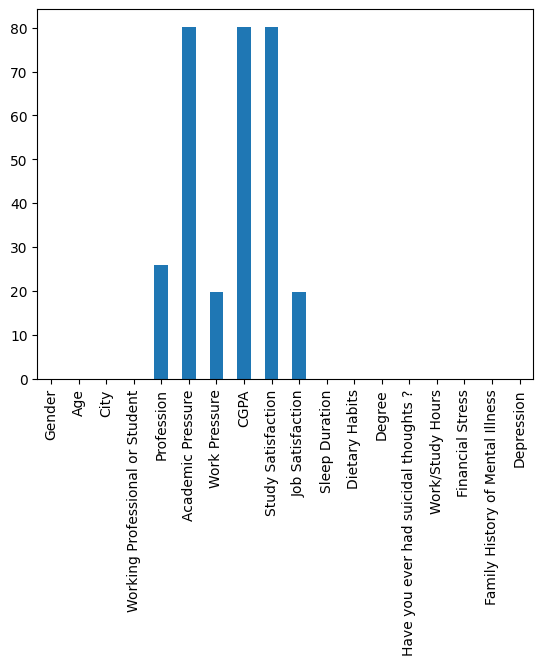

In [14]:
miss = train.isnull().sum()/len(train)*100
miss.plot(kind='bar')

**EDA**

In [61]:
target = "Depression"
num_cols = ['Age', 'Work/Study Hours','Financial Stress']
cat_cols = ['Gender', 'City', 'Working Professional or Student','Sleep Duration', 'Dietary Habits', 'Degree','Have you ever had suicidal thoughts ?','Family History of Mental Illness', 'Depression']

In [43]:
train["Depression"].value_counts()

Depression
0      115133
1       25567
No       2101
Yes       455
Name: count, dtype: int64

In [44]:
def clean_target(txt):
    txt = str(txt).lower().strip()
    if txt=='no':
        return 0
    elif txt=='yes':
        return 1
    return int(txt)

In [47]:
train["Depression"] = train["Depression"].apply(clean_target)
train["Depression"].value_counts()

Depression
0    117234
1     26022
Name: count, dtype: int64

<Axes: ylabel='count'>

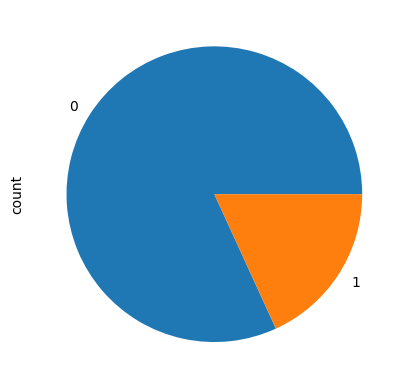

In [65]:
train["Depression"].value_counts().plot(kind='pie')

**Analyzing Numerical Columns**

In [67]:
for col in num_cols:
    print(f"Value counts for {col}:")
    print(train[col].value_counts())
    print("###########################################\n")  

Value counts for Age:
Age
56.0    5319
49.0    5171
38.0    4635
53.0    4589
57.0    4457
47.0    4265
46.0    4144
51.0    3990
54.0    3987
18.0    3981
43.0    3915
59.0    3842
48.0    3754
45.0    3592
20.0    3580
50.0    3502
42.0    3456
24.0    3424
28.0    3411
39.0    3321
44.0    3268
33.0    3212
41.0    3197
29.0    3168
40.0    3155
25.0    2992
58.0    2981
23.0    2953
55.0    2897
35.0    2895
21.0    2795
37.0    2775
36.0    2759
19.0    2681
27.0    2670
34.0    2642
52.0    2635
31.0    2622
60.0    2551
26.0    2160
22.0    2117
30.0    1967
32.0    1829
Name: count, dtype: int64
###########################################

Value counts for Work/Study Hours:
Work/Study Hours
10.0    14417
11.0    13037
9.0     12921
0.0     12270
12.0    11600
2.0     10801
6.0     10627
7.0     10058
1.0      9993
3.0      9666
5.0      9534
4.0      9251
8.0      9081
Name: count, dtype: int64
###########################################

Value counts for Financial Stress:
Fina

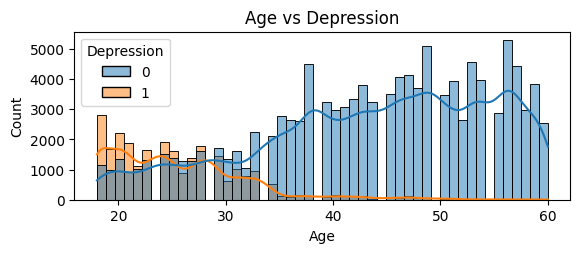

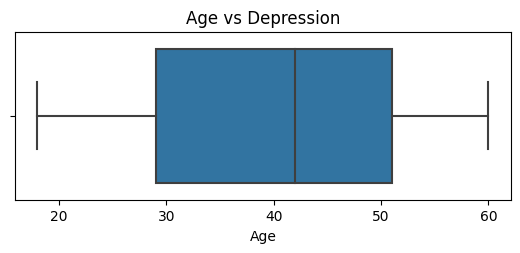

In [82]:
plt.subplot(2,1,1)
sns.histplot(train,x='Age',kde=True,hue='Depression')
plt.title('Age vs Depression')
plt.show()

plt.subplot(2,1,2)
sns.boxplot(train,x='Age')
plt.title('Age vs Depression')
plt.show()

**Hence Younger People are more prone to Depression**

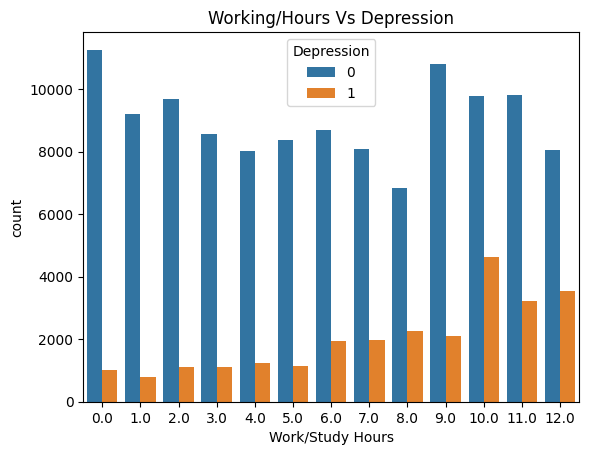

In [76]:
sns.countplot(train,x='Work/Study Hours',hue='Depression')
plt.title("Working/Hours Vs Depression")
plt.show()

**As the working hours increase there is a surge in Depression**

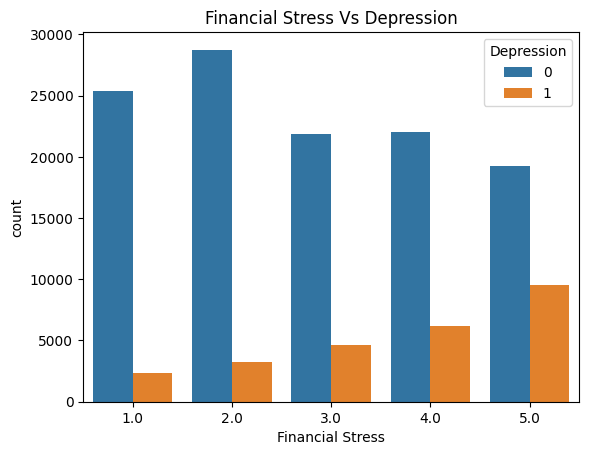

In [77]:
sns.countplot(train,x='Financial Stress',hue='Depression')
plt.title("Financial Stress Vs Depression")
plt.show()

**As the level of financial stress increases so does the level of depression**

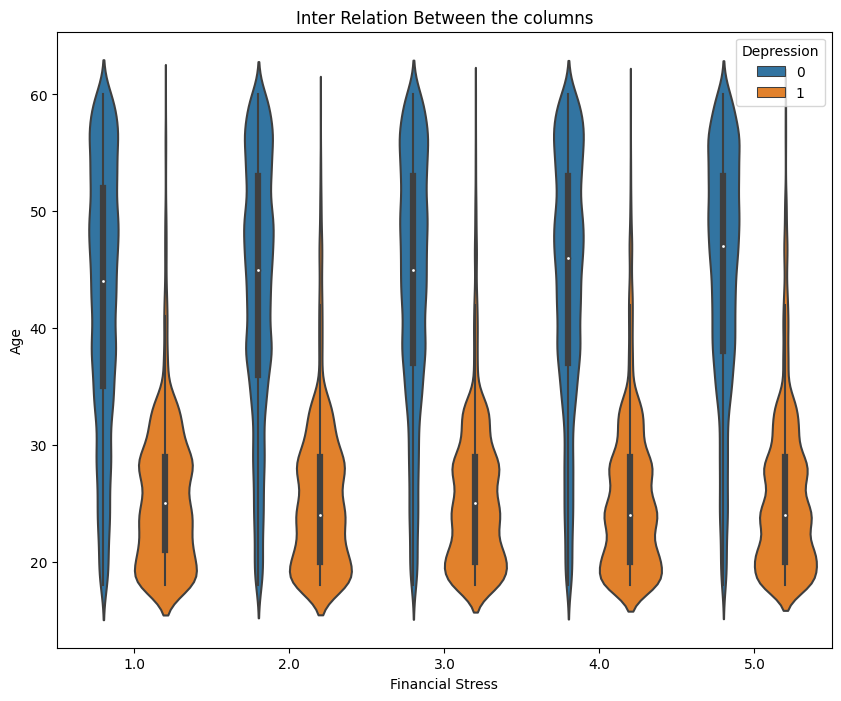

In [88]:
plt.figure(figsize=(10,8))
sns.violinplot(train,x='Financial Stress',y='Age',hue='Depression')
plt.title('Inter Relation Between the columns')
plt.show()

**Young People Between the age of 20-30 have a high tendency of depression. We can also conclude that Age alone can explain the distribution of Depression as compared to Financial Stress**

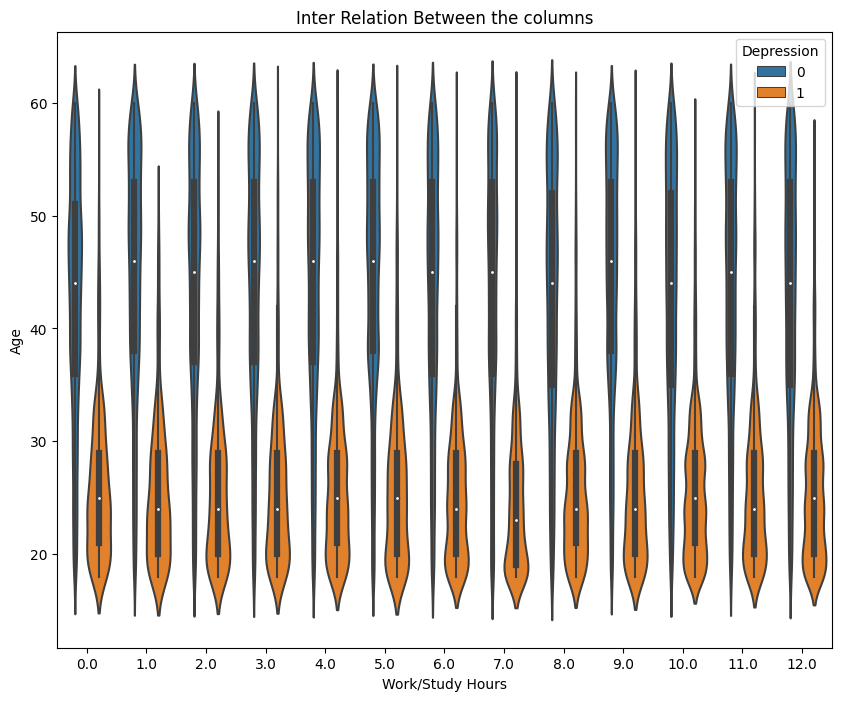

In [94]:
plt.figure(figsize=(10,8))
sns.violinplot(train,x='Work/Study Hours',y='Age',hue='Depression')
plt.title('Inter Relation Between the columns')
plt.show()

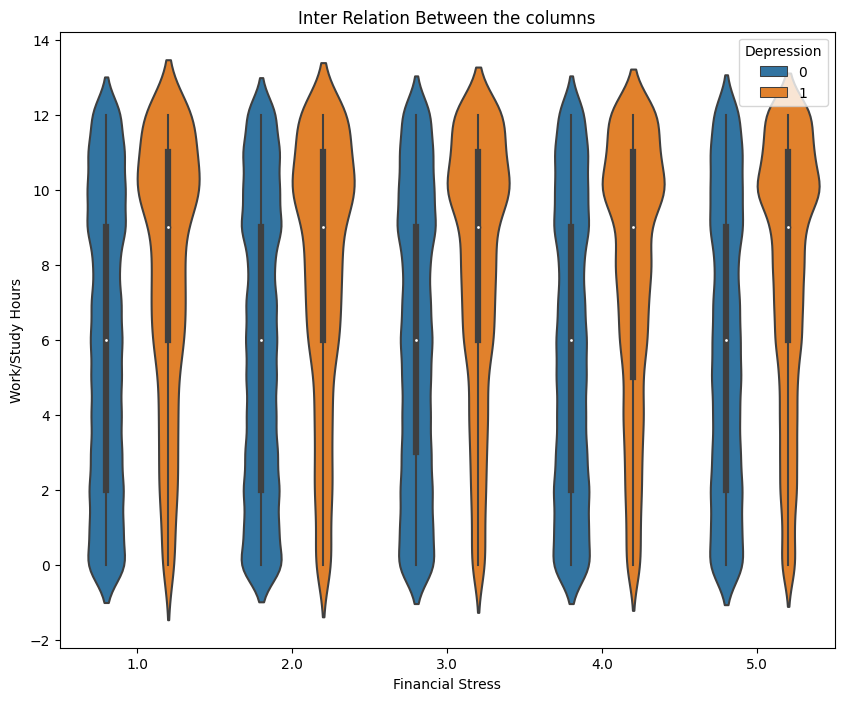

In [96]:
plt.figure(figsize=(10,8))
sns.violinplot(train,y='Work/Study Hours',x='Financial Stress',hue='Depression')
plt.title('Inter Relation Between the columns')
plt.show()

**These two parameters have a kind of equal say in this context**

**Analyzing categorical columns**

In [98]:
for col in cat_cols:
    print(f"Value counts for {col}:")
    print(train[col].value_counts())
    print("###########################################\n")  

Value counts for Gender:
Gender
Male      78797
Female    64459
Name: count, dtype: int64
###########################################

Value counts for City:
City
Kalyan         6683
Patna          6013
Vasai-Virar    5860
Kolkata        5776
Ahmedabad      5705
               ... 
Shrey             1
Ivaan             1
Vaanya            1
Gaurav            1
Unirar            1
Name: count, Length: 98, dtype: int64
###########################################

Value counts for Working Professional or Student:
Working Professional or Student
Working Professional    114853
Student                  28403
Name: count, dtype: int64
###########################################

Value counts for Sleep Duration:
Sleep Duration
Less than 5 hours    39432
7-8 hours            37627
More than 8 hours    33348
5-6 hours            32770
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
1

In [104]:
city_cnt = train['City'].value_counts()
city_names = city_cnt.index
city_names

Index(['Kalyan', 'Patna', 'Vasai-Virar', 'Kolkata', 'Ahmedabad', 'Meerut',
       'Ludhiana', 'Pune', 'Rajkot', 'Visakhapatnam', 'Srinagar', 'Mumbai',
       'Indore', 'Agra', 'Surat', 'Varanasi', 'Vadodara', 'Hyderabad',
       'Kanpur', 'Jaipur', 'Thane', 'Lucknow', 'Nagpur', 'Bangalore',
       'Chennai', 'Ghaziabad', 'Delhi', 'Bhopal', 'Faridabad', 'Nashik',
       'Mihir', 'Nandini', 'Saanvi', 'Mahi', 'Vidya', 'City', 'Pratyush',
       'Harsha', 'Bhavna', 'Molkata', 'MCA', 'M.Com', 'Atharv', 'Nalini',
       'Keshav', 'Ayush', 'M.Tech', 'Researcher', 'Vaishnavi', 'Chhavi',
       'Parth', 'Vidhi', 'Tushar', 'MSc', 'No', 'Rashi', 'ME', 'Ishanabad',
       'Armaan', 'Kagan', 'Kashish', 'Ithal', 'Nalyan', 'Dhruv', 'Galesabad',
       'Itheg', 'Aaradhya', 'Pooja', 'Khushi', 'Khaziabad', 'Jhanvi', 'Kibara',
       'Harsh', 'Reyansh', 'Morena', 'Less Delhi', 'Malyansh', 'Aditya',
       'Plata', 'Aishwarya', '3.0', 'Less than 5 Kalyan', 'Krishna', 'Mira',
       'Moreadhyay', 'Ishkarsh

In [110]:
people_names = [
    'Mihir', 'Nandini', 'Saanvi', 'Mahi', 'Vidya', 
    'Pratyush', 'Harsha', 'Bhavna', 'Atharv', 'Nalini', 
    'Keshav', 'Ayush', 'Vaishnavi', 'Chhavi', 'Parth', 
    'Vidhi', 'Tushar', 'Rashi', 'Armaan', 'Kagan', 
    'Kashish', 'Dhruv', 'Aaradhya', 'Pooja', 'Khushi', 
    'Jhanvi', 'Kibara', 'Harsh', 'Reyansh', 'Aditya', 
    'Aishwarya', 'Krishna', 'Mira', 'Ishkarsh', 'Raghavendra', 
    'Anvi', 'Krinda', 'Ayansh', 'Shrey', 'Ivaan', 
    'Vaanya', 'Gaurav'
]

corrected_cities = {
    'Patna': 'Patna',
    'Vasai-Virar': 'Vasai-Virar',
    'Kolkata': 'Kolkata',
    'City': 'Unknown',
    'MCA': 'Unknown',
    'M.Com': 'Unknown',
    'M.Tech': 'Unknown',
    'Researcher': 'Unknown',
    'MSc': 'Unknown',
    'ME': 'Unknown',
    'Ishanabad': 'Ishwar Nagar',  # Likely refers to a neighborhood, not widely recognized as a city
    'Ithal': 'Unknown',  # Not widely recognized
    'Nalyan': 'Navi Mumbai',  # Possible close reference to a known area
    'Galesabad': 'Galsi',  # Possible close reference to a known area
    'Itheg': 'Unknown',  # Not a valid city name
    'Khaziabad': 'Ghaziabad',  # Correction for Ghaziabad
    'Morena': 'Morena',
    'Less Delhi': 'Delhi',  # A misleading representation of Delhi
    'Malyansh': 'Unknown',  # Not a valid city name
    'Plata': 'Unknown',  # Not a valid city name
    '3.0': 'Unknown',  # Not a valid city name
    'Less than 5 Kalyan': 'Kalyan',  # Misleading representation of Kalyan
    'Tolkata': 'Kolkata',  # Spelling correction for Kolkata
    'Unirar': 'Unknown',
     'Molkata':'Kolkata',
    'No':'Unknown',
    'Moreadhyay':'Moradabad',
    'Kashk':'kashi',
}


In [111]:
def clean_city(city):
    if city in people_names:
        return 'Unknown'
    elif city in corrected_cities.keys():
        return corrected_cities[city]
    else:
        return city

In [112]:
train['City'] = train['City'].apply(clean_city)
train['City'].value_counts()

City
Kalyan           6684
Patna            6013
Vasai-Virar      5860
Kolkata          5779
Ahmedabad        5705
Meerut           5629
Ludhiana         5314
Pune             5308
Rajkot           5303
Visakhapatnam    5260
Srinagar         5176
Mumbai           5065
Indore           4954
Agra             4769
Surat            4716
Varanasi         4689
Vadodara         4656
Hyderabad        4581
Kanpur           4482
Jaipur           4408
Thane            4369
Lucknow          4355
Nagpur           4287
Bangalore        4199
Chennai          4132
Ghaziabad        3689
Delhi            3668
Bhopal           3556
Faridabad        3341
Nashik           3217
Unknown            85
Ishwar Nagar        1
Gurgaon             1
Moradabad           1
Morena              1
kashi               1
Navi Mumbai         1
Galsi               1
Name: count, dtype: int64

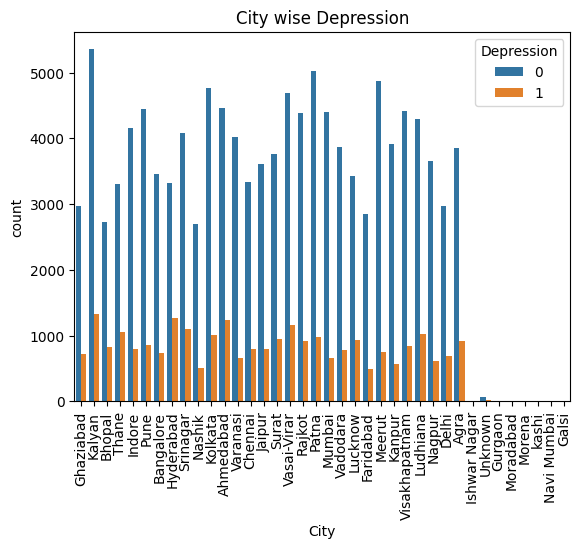

In [114]:
sns.countplot(train,x='City',hue='Depression')
plt.title("City wise Depression")
plt.xticks(rotation=90)
plt.show()

**Cities like Hyderabad, Vasai-Virar, Lucknow, Agra, Ludhiana, Kalyan, Thane, Srinagar, Ahmedabad**

<Axes: ylabel='count'>

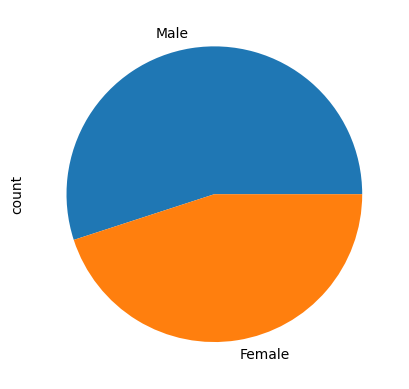

In [115]:
train['Gender'].value_counts().plot(kind='pie')

In [119]:
train['Sleep Duration'].value_counts()

Sleep Duration
Less than 5 hours    39432
7-8 hours            37627
More than 8 hours    33348
5-6 hours            32770
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
1-6 hours                4
No                       4
9-11 hours               2
10-11 hours              2
Sleep_Duration           2
Unhealthy                2
45                       2
8-9 hours                2
10-6 hours               1
9-5                      1
45-48 hours              1
3-6 hours                1
Work_Study_Hours         1
49 hours                 1
than 5 hours             1
Pune                     1
9-6 hours                1
8 hours                  1
35-36 hours              1
Indore                   1
1-3 hours                1
55-66 hours              1
Moderate                 1
40-45 hours              1
1-2 hours                1
9-5 hours                1
Name: count, 

In [121]:
invalid_entry = ['No','Unhealthy','Sleep_Duration','Pune','Moderate','Indore','Work_Study_Hours']
meaningless_entry = ['45','45-48 hours','49 hours','35-36 hours','55-66 hours','40-45 hours']
#correct_map={'Less than 5 hours':5,'7-8 hours':7.5,'More than 8 hours':8,'5-6 hours':5.5,'3-4 hours',3.5,'6-7 hours':6.5,'4-5 hours':4.5,'2-3 hours':2.5,'4-6 hours':5,'6-8 hours':7,'1-6 hours':3,'9-11 hours':10,'10-11 hours':10,'8-9 hours':8.5,'10-6 hours':8,'3-6 hours':5,'9-6 hours':7.5,'8 hours':8,'1-3 hours':2,'1-2 hours':1.5,'9-5 hours':7}
correct_map = {
    'Less than 5 hours': 5,
    '7-8 hours': 7.5,
    'More than 8 hours': 8,
    '5-6 hours': 5.5,
    '3-4 hours': 3.5,  # Added a colon here
    '6-7 hours': 6.5,
    '4-5 hours': 4.5,
    '2-3 hours': 2.5,
    '4-6 hours': 5,
    '6-8 hours': 7,
    '1-6 hours': 3,
    '9-11 hours': 10,
    '10-11 hours': 10,
    '8-9 hours': 8.5,
    '10-6 hours': 8,
    '3-6 hours': 5,
    '9-6 hours': 7.5,
    '8 hours': 8,
    '1-3 hours': 2,
    '1-2 hours': 1.5,
    '9-5 hours': 7
}

In [122]:
def clean_sleep(sleep):
    sleep = str(sleep)
    if sleep in invalid_entry:
        return 0
    elif sleep in meaningless_entry:
        return 10
    elif sleep in correct_map.keys():
        return correct_map[sleep]
    else:
        return 0

In [123]:
train['Sleep Duration'] = train['Sleep Duration'].apply(clean_sleep)
train['Sleep Duration'].value_counts()

Sleep Duration
5.0     39438
7.5     37628
8.0     33350
5.5     32770
0.0        14
3.5        12
10.0       11
6.5         8
4.5         7
7.0         5
2.5         5
3.0         4
8.5         2
1.5         1
2.0         1
Name: count, dtype: int64

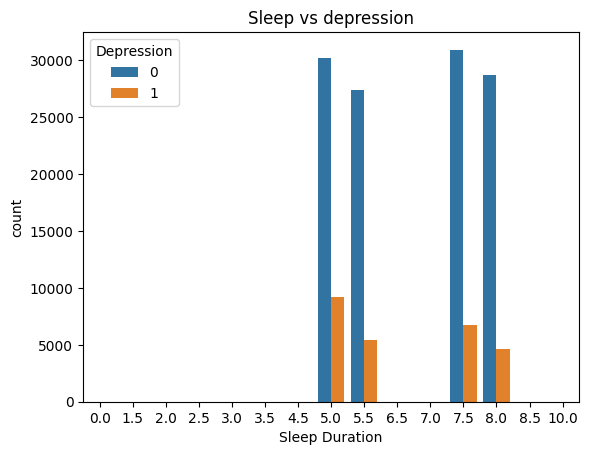

In [124]:
sns.countplot(train,x='Sleep Duration',hue='Depression')
plt.title("Sleep vs depression")
plt.show()

**This chart may not give the right idea because of the nature of cleaning. Here i have just replaced the range eg.(1-5) with their average ,ie,3. Different cleaning process will give different result**

<Axes: ylabel='count'>

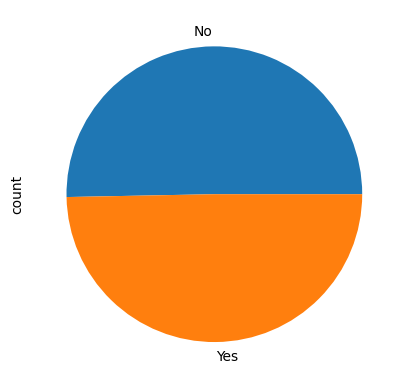

In [125]:
train['Family History of Mental Illness'].value_counts().plot(kind='pie')

**WOW!! what an even Distribution**

<Axes: ylabel='count'>

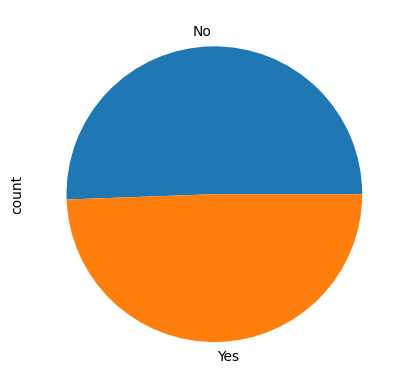

In [128]:
train['Have you ever had suicidal thoughts ?'].value_counts().plot(kind='pie')

**A similar even curve**

In [134]:
deg_cnt = train['Degree'].value_counts()

def clean_degree(value):
    count = deg_cnt.get(value, 0)
    return value if count >= 100 else 'Unknown'

In [135]:
train['Degree'] = train['Degree'].apply(clean_degree)
train['Degree'].value_counts()

Degree
Class 12    15004
B.Ed        11803
B.Arch       8831
B.Com        8228
B.Pharm      5944
BCA          5842
M.Ed         5749
MCA          5342
BBA          5122
BSc          5121
MSc          4974
LLM          4731
M.Pharm      4622
M.Tech       4560
B.Tech       4496
LLB          4430
BHM          4395
MBA          3913
BA           3839
ME           3716
MD           3457
MHM          3367
BE           3188
PhD          3184
M.Com        3159
MBBS         3157
MA           2966
Unknown       116
Name: count, dtype: int64

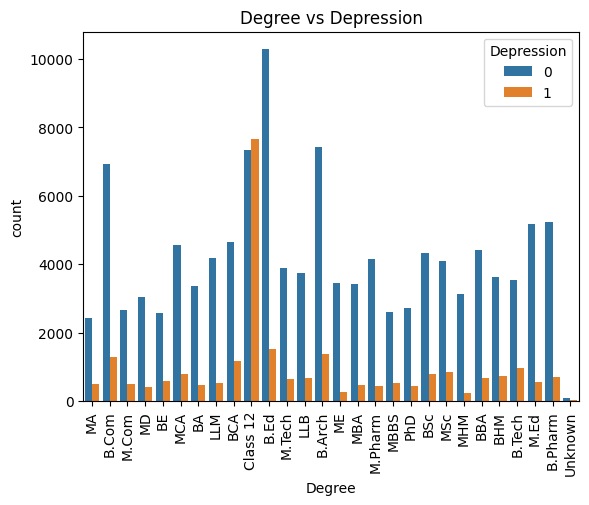

In [137]:
sns.countplot(train,x='Degree',hue='Depression')
plt.title("Degree vs Depression")
plt.xticks(rotation=90)
plt.show()

**People who have just studied uptill class 12 are the most depressed and I though Engineers are the most depressed Hahahah!!!**

In [140]:
diet_cnt = train['Dietary Habits'].value_counts()

def clean_diet(value):
    count = diet_cnt.get(value, 0)
    return value if count >= 100 else 'Unknown'

In [141]:
train['Dietary Habits'] = train['Dietary Habits'].apply(clean_diet)
train['Dietary Habits'].value_counts()

Dietary Habits
Moderate     50537
Unhealthy    47109
Healthy      45583
Unknown         27
Name: count, dtype: int64

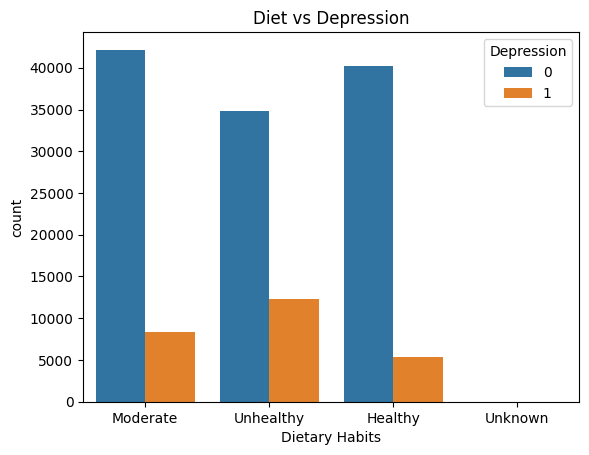

In [142]:
sns.countplot(train,x='Dietary Habits',hue='Depression')
plt.title("Diet vs Depression")
plt.show()

**As expected People with unhealthy Diet are the among the most Depressed**